# Solving the maximum margin problem with quadratic programming (QP) and the RBF kernel

The best QP solver for Python is "cvxopt."

First, let's set up synthetic data forming a well separated annulus.


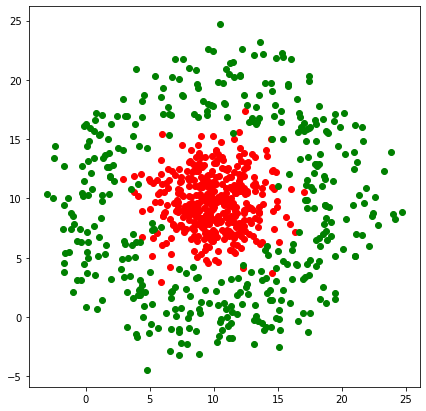

In [25]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt

# Gaussian center of the annulus

m_per_class = 400

mu = np.array([10, 10])
sigma = np.array([[6, 0], [0, 6]])
X1 = np.random.multivariate_normal(mu, sigma, m_per_class)

# Outer ring of annulus

r = 10
sigma = 2
theta = np.random.uniform(0, 2 * np.pi, m_per_class)
r = r + np.random.normal(0, sigma, m_per_class)
x, y = 10 + np.cos(theta) * r, 10 + np.sin(theta) * r
X2 = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), 1)
plt.figure(figsize = (7,7))
plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'go')
plt.show()


In [26]:
# Combine the classes and set targets

X = np.concatenate((X1, X2), 0)
y = np.concatenate((-np.ones((m_per_class, 1)), np.ones((m_per_class, 1))), 0)
m = X.shape[0]
n = 2

def cvxopt_solve_qp(Q, c, A=None, b=None, E=None, d=None):
    Q = .5 * (Q + Q.T)  # make sure Q is symmetric
    args = [cvxopt.matrix(Q), cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
        if E is not None:
            args.extend([cvxopt.matrix(E), cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((Q.shape[1],))


In [27]:

# Kernels

def linear_kernel(X):
    return X @ X.T


def rbf_kernel(X, sigma):
    m = X.shape[0]
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = (X[i,:] - X[j,:]) @ (X[i,:] - X[j,:])
    K = np.exp(- K / 2 / sigma / sigma)
    return K
        
            
# QP problem: set Q, c, A, b

# Parameters are alpha's

# max_alpha [sum of alphas] - 1/2 sum_i,j alpha_i alpha_j y^i y^j <x^i,x^j>
# alpha_i >= 0
# sum alpha_i * y^i = 0

m = X.shape[0]
rbf_sigma = 2
c = - np.ones((m, 1))
# Q = (y @ y.T) * linear_kernel(X, rbf_sigma)
Q = (y @ y.T) * rbf_kernel(X, rbf_sigma)
A = - np.eye(m)
b = np.zeros((m, 1))
E = y.T
d = np.zeros((1, 1))

opt_params = cvxopt_solve_qp(Q, c, A, b, E, d)


     pcost       dcost       gap    pres   dres
 0: -7.4942e+01 -2.5463e+02  3e+03  3e+01  3e+00
 1: -2.3036e+02 -5.6136e+02  2e+03  2e+01  2e+00
 2: -5.8483e+02 -9.9777e+02  1e+03  1e+01  1e+00
 3: -1.1120e+03 -1.6201e+03  2e+03  1e+01  1e+00
 4: -1.3762e+03 -1.9252e+03  2e+03  1e+01  1e+00
 5: -3.1612e+03 -3.9289e+03  2e+03  1e+01  1e+00
 6: -6.9856e+03 -8.2996e+03  2e+03  1e+01  1e+00
 7: -1.3660e+04 -1.6490e+04  4e+03  9e+00  8e-01
 8: -1.9573e+04 -2.3628e+04  6e+03  6e+00  5e-01
 9: -2.1165e+04 -2.3792e+04  4e+03  3e+00  2e-01
10: -2.1058e+04 -2.1369e+04  3e+02  2e-12  1e-12
11: -2.1275e+04 -2.1283e+04  7e+00  4e-12  1e-12
12: -2.1281e+04 -2.1281e+04  7e-02  2e-11  1e-12
13: -2.1281e+04 -2.1281e+04  7e-04  5e-12  1e-12
Optimal solution found.


In [28]:
print('Alphas that are not zero:', opt_params[opt_params > 1e-5])
print('Corresponding labels:', y[opt_params > 1e-5])
opt_params[opt_params > 1e-5] @ y[opt_params > 1e-5]

Alphas that are not zero: [2.88576799e+01 1.14559717e+03 2.89937392e+01 2.69537211e+03
 4.36525743e+02 4.66625758e+02 3.66732650e+01 7.70739040e+02
 7.89087144e+01 1.16066523e+02 3.65123192e+02 8.45729249e+03
 2.08709533e+03 1.24726777e+02 1.87305451e+02 1.85187058e+01
 1.79924144e+02 8.44093355e+00 6.78038652e+02 1.10394751e+03
 3.09756324e+02 1.54875068e+02 4.22742440e+02 1.37909922e+03
 1.08517309e+03 2.78624707e+01 9.34549082e+00 1.69794906e+03
 2.37303092e-05 2.61732236e+02 2.13696330e+02 1.76957542e+02
 9.54980424e+02 1.63586736e+01 2.90680648e+02 1.53085007e+01
 3.92595935e+02 2.96496121e+03 6.30707913e+01 1.01430972e+03
 1.52462003e+02 1.93956502e+02 1.87254384e+03 3.07605955e+02
 3.84050145e+02 7.86805353e+02 3.01062999e+02 3.85206439e+01
 4.36161331e+02 3.65917019e+02 6.52532868e+03 7.28537169e+02
 3.31219706e+00]
Corresponding labels: [[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [

array([1.03733555e-05])

In [29]:
# How to perform inference with a kernel rather than w,b?

def b_from_alpha(X, y, alpha, rbf_sigma):
    S = np.where(alpha > 1e-5)[0]
    alpha_s = alpha[S].reshape(-1,1)
    y_s = y[S]
    X_s = X[S,:]
    b = (y_s - ((alpha_s * y_s).T * rbf_kernel(X_s, rbf_sigma)).sum(axis=1, keepdims=True)).mean()
    return b

def rbf_kernel_1(x, xprime, rbf_sigma):
    return np.exp(- (x - xprime) @ (x - xprime) / 2 / rbf_sigma / rbf_sigma)
    
def svm_predict(x, X, y, alpha, rbf_sigma):
    b = b_from_alpha(X, y, alpha, rbf_sigma)
    results = np.zeros((x.shape[0], 1))
    for i in range(x.shape[0]):
        results[i] = 0
        for j in range(X.shape[0]):
            results[i, 0] += alpha[j] * y[j, 0] * rbf_kernel_1(x[i,:], X[j,:], rbf_sigma)
        results[i] += b
    return np.sign(results)

# svm_predict(np.array([[10, 10], [20, 20]]), X, y, opt_params, rbf_sigma)

In [30]:
train_pred = svm_predict(X, X, y, opt_params, rbf_sigma)
accuracy = (train_pred == y).mean()
print('Training accuracy:', accuracy)

Training accuracy: 1.0


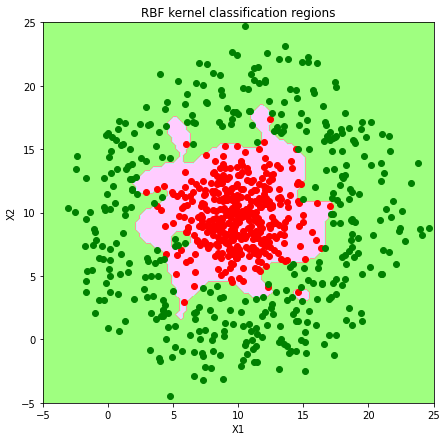

In [31]:
# plt.plot((x11, x12), (x21, x22), 'k-')


from matplotlib.colors import ListedColormap
custom_cmap =ListedColormap(['#ffccff','#b3fff0','#ff9999','#9fff80'])
plt.figure(figsize = (7,7))

plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'go')

# Overlay colored regions according to svm_predict

grid_x, grid_y = np.mgrid[-5:25:100j, -5:25:100j]
grid_xy = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
grid_z = svm_predict(grid_xy, X, y, opt_params, rbf_sigma).reshape((100, 100))

plt.contourf(grid_x, grid_y, grid_z,cmap=custom_cmap)

plt.title('RBF kernel classification regions')
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()